In [1]:
# Import basics
import sys, os
import numpy as np

sys.path.append('../python/')
import load

from scipy import stats, ndimage, interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plotting Settings
mpl.rcParams['axes.labelsize'] = 24 # default figure size
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


# Raw and Calibrated Observational Data

## Load and Downbin the Raw Observation Data
The time-integreated GBT data are provided at full-frequency resolution as nupmy dictionaries for each observation target and each subband. The data without time-series filtering is found in `../data/GBT_DATA/Unfiltered_Data/`. The data with time-series filtering is found in `../data/GBT_DATA/Filtered_Data/`

A utility module for loading and joining the GBT data `load` is provided in `'../python/'`. To load the data, provide the data directory and observation identification as arguments in `load.load`. The data may be downbinned using the `downsample` optional argument and shifted half the downbinned frequency channel width with the `do_shift` optional argument. Our analysis is performed at a downsampling factor of `10`.

In [2]:
M31_Data = load.load('../data/GBT_Data/Filtered_Data/', 'M31', downsample = 1, do_shift = False)

M31_Freqs = M31_Data[0]  # The central frequency for each frequency channel, GHz
M31_AntennaTemp = M31_Data[1] # The antenna temperature at each frequency channel, K
M31_Sig = M31_Data[2] # The ON Position measurement for each frequency channel, Raw Antenna Counts
M31_Ref = M31_Data[3] # The OFF Position measurement for each frequency channel, Raw Antenna Counts
M31_SigAccept = M31_Data[4] # The fraction of ON Position measurements accepted at each frequency channnel
M31_RefAccept = M31_Data[5] # The fraction of OFF Position measurements accepted at each frequency channnel


M31_A.npz


## Infer a Calibration Function

Identically formatted GBT with observations of calibration sources used to infer a flux density spectrum from the antenna temperature are provided in the GBT data directory. Each target observation has a matching calibration observation from the same observing session in the same mode. The table below provides the appropriate calibration observation for each target observation.


| Observation Target | Calibration Observation |
| ------------- | ------------- |
| RX$-$J0720 | 3C48_mode9 |
| RX$-$J0806 | 3C48_mode9|
| M31 | 3C48_mode2 |
| Galactic Center | 3C286_mode2 |
| Galactic Center Offset | 3C286_mode2|
| M54 | 3C286_mode4 |



The calibration observations corresponds to sources with well-characterized flux density spectra so that the antenna temperature may be calibrated against the expected flux density measurement.  The calibration antenna temperature is first smoothed with a median filter in order to improve the signal-to-noise, resulting in a better behaved calibration function.

In [3]:
Cal_Data = load.load('../data/GBT_Data/Filtered_Data/', '3C48_mode2', downsample = 1, do_shift = False)

Cal_Freqs = Cal_Data[0]  # The central frequency for each frequency channel, GHz
Cal_AntennaTemp = Cal_Data[1] # The antenna temperature at each frequency channel, K

Cal_Func = load.get_expected(Cal_Freqs, '3C48') / ndimage.median_filter(Cal_AntennaTemp, size = 31)

3C48_mode2_A.npz


## Reduce the Data

The raw data is provided at frequencies outside the data-taking range for each observation. Following GBT documentation, the LBand should be reduced to the frequency range `1.15 - 1.73 GHz`. We also mask out data at the location of the notch filter in the frequency range `1.2  - 1.35 GHz`.

In [4]:
locs = np.where(np.logical_and(M31_Freqs >= 1.15, M31_Freqs <= 1.73))

for item in [M31_Freqs, M31_AntennaTemp, M31_Sig, M31_Ref, M31_SigAccept, M31_RefAccept, Cal_Func]:
    item = item[locs]

mask_locs = np.where(np.logical_and(M31_Freqs >= 1.2, M31_Freqs <= 1.34))
mask = np.ones_like(M31_Freqs)
mask[mask_locs] = np.nan

## Plot the Calibrated Flux Density Spectra

/sw/lsa/centos7/python-anaconda2/2019.03/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


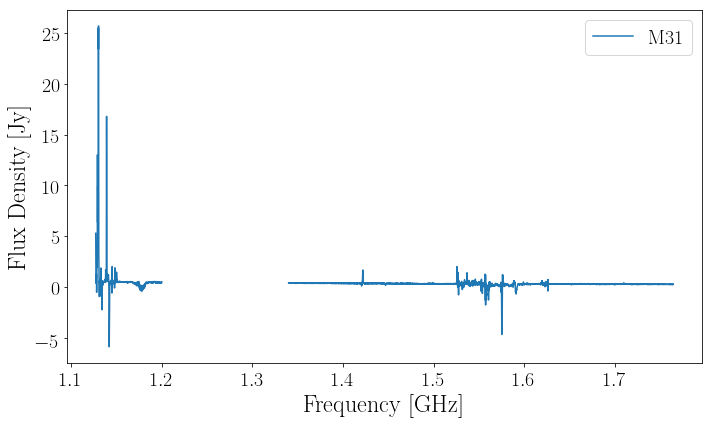

In [5]:
mpl.rcParams['figure.figsize'] = 10, 6 # default figure size


plt.plot(M31_Freqs, mask*(Cal_Func * M31_AntennaTemp), label = 'M31')

plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux Density [Jy]')

plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()